In [88]:
%matplotlib notebook

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

from pytopo.qctools.instruments import create_inst
from pytopo.mplplots.init_nb_plotting import *

# Tools

## Definitions

In [537]:
def dummy_data(nsamples, nrecords, nbuffers, sample_rate=1e9, 
               frq=20e6, nbits=12):
    
    tvals = np.arange(nsamples, dtype=np.float32) / sample_rate
    bb, rr, ss = np.meshgrid(
        np.ones(nbuffers),
        np.arange(nrecords) * (2*np.pi/nrecords),
        tvals,
        indexing='ij',
    )
    data = np.zeros((nbuffers, nrecords, nsamples, 2))
    data[..., 0] = 0.1 * bb * np.cos(2*np.pi*ss*frq + rr)
    data[..., 1] = 0.4 * np.sin(2*np.pi*ss*frq)
    data[:,:,:nsamples//4,0] = 0
    data[:,:,3*nsamples//4:,0] = 0
    data *= (2048 * 2)
    data += 2048
    data = data.astype(np.uint16)
    data <<= 4
    return tvals, data


class CtlTest:
    
    def __init__(self, ctl, nsamples, nrecords, nbuffers, sample_rate=1e9, frq=20e6):
        self.tvals, self.data = dummy_data(nsamples, nrecords, nbuffers, sample_rate, frq)
        
        self.ctl = ctl
        self.ctl.sample_rate(sample_rate)
        self.ctl.buffers_per_acquisition(nbuffers)
        self.ctl.records_per_buffer(nrecords)
        self.ctl.samples_per_record(nsamples)
        if hasattr(self.ctl, 'demod_frq'):
            self.ctl.demod_frq(frq)
        
    def run(self):
        self.ctl.pre_start_capture()
        for i in range(self.ctl.buffers_per_acquisition()):
            self.ctl.handle_buffer(self.data[i, ...], i)
        self.data = self.ctl.post_acquire()
            
        ht = np.mean(self.ctl.handling_times)
        uht = np.std(self.ctl.handling_times)
        norm_ht = 1e-3 * ht / ((self.ctl.samples_per_record() * self.ctl.records_per_buffer()) / self.ctl.sample_rate())
        mbps = (self.ctl.samples_per_record() * self.ctl.records_per_buffer() * 2 * 2) / (1e-3 * ht) / (1024**2)
        
        
        return ht, uht, norm_ht, mbps

## Testing

<IPython.core.display.Javascript object>


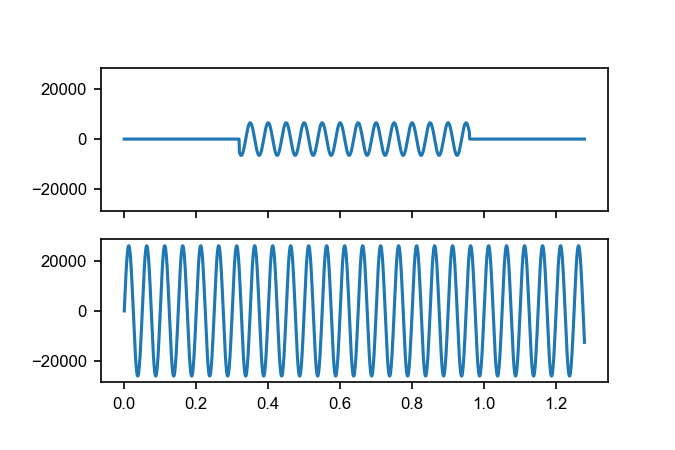

In [510]:
frq = 20e6
SR = 1e9
period = int(SR/frq)

tvals, data = dummy_data(10*128, 1, 1, SR, frq=frq)
data.dtype = np.int16
data -= 2048 * 16
# data /= 16

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
ax = axes[0]
ax.plot(tvals * 1e6, (np.squeeze(data)[...,0]))
ax = axes[1]
ax.plot(tvals * 1e6, (np.squeeze(data)[...,1]))

<IPython.core.display.Javascript object>


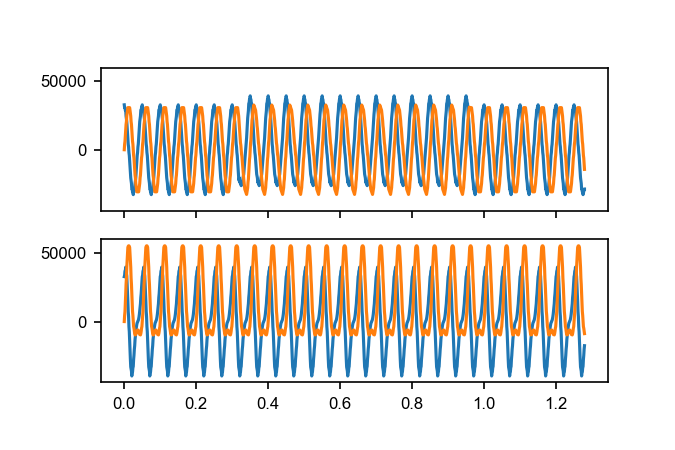

In [508]:
tvals, data = dummy_data(10*128, 1, 1, SR, frq=frq)

ref_r = (16 * np.cos(2*np.pi*frq*tvals)).astype(np.int16).reshape(1, 1, tvals.size, 1)
ref_i = (16 * np.sin(2*np.pi*frq*tvals)).astype(np.int16).reshape(1, 1, tvals.size, 1)

# np.array([ 
#     fun(2*np.pi*frq*tvals) * 2048 for fun in [np.cos, lambda x: -np.sin(x)] 
# ]).reshape((1, 1, tvals.size, 1, 2)).astype(np.int16)

data.dtype = np.uint16
data = np.right_shift(data, 4)
data_r = data * ref_r
data_i = data * ref_i

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

ax = axes[0]
ax.plot(tvals * 1e6, (np.squeeze(data_r)[...,0]))
ax.plot(tvals * 1e6, (np.squeeze(data_i)[...,0]))
ax = axes[1]

ax.plot(tvals * 1e6, (np.squeeze(data_r)[...,1]))
ax.plot(tvals * 1e6, (np.squeeze(data_i)[...,1]))

<IPython.core.display.Javascript object>


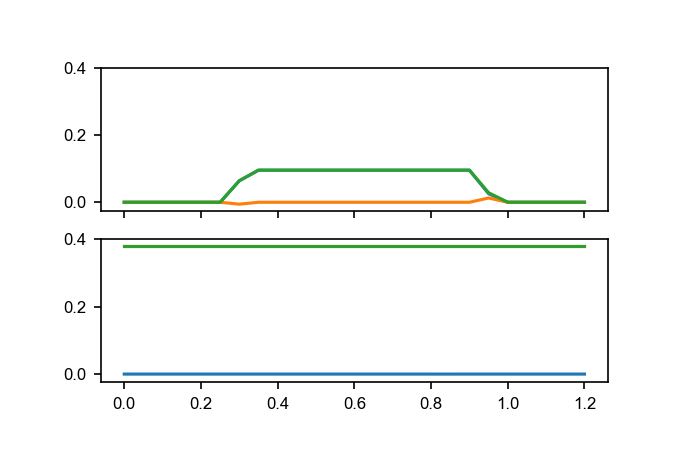

In [511]:
demod_samples = tvals.size//period
demod_tvals = tvals[::period][:demod_samples]

demod_r = data_r[:,:,:demod_samples*period,:].reshape(1,1,demod_tvals.size,period,2).mean(axis=-2)
demod_i = data_i[:,:,:demod_samples*period,:].reshape(1,1,demod_tvals.size,period,2).mean(axis=-2)

demod_r = np.squeeze(demod_r) / 2048 / 16
demod_i = np.squeeze(demod_i) / 2048 / 16

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
ax = axes[0]
ax.plot(demod_tvals * 1e6, demod_r[...,0])
ax.plot(demod_tvals * 1e6, demod_i[...,0])
ax.plot(demod_tvals * 1e6, ((demod_r**2 + demod_i**2)**.5)[...,0])

ax = axes[1]
ax.plot(demod_tvals * 1e6, demod_r[...,1])
ax.plot(demod_tvals * 1e6, demod_i[...,1])
ax.plot(demod_tvals * 1e6, ((demod_r**2 + demod_i**2)**.5)[...,1])

# Acquisition controllers

## Definitions

In [594]:
from qcodes.instrument_drivers.AlazarTech.ATS import AcquisitionController

class BaseAcqCtl(AcquisitionController):

    ZERO = np.int16(2048)
    RANGE = 2047.5
    MINSAMPLES = 384
    DATADTYPE = np.uint16

    def __init__(self, name, alazar_name, **kwargs):
        self.acquisitionkwargs = {}
        self.number_of_channels = 2
        self.trigger_func = None
        
        self._average_buffers = False

        try:
            super().__init__(name, alazar_name, **kwargs)
        except KeyError:
            self._alazar = None
        
        if self._alazar is not None:
            alz = self._get_alazar()
            self.add_parameter('sample_rate', get_cmd=alz.sample_rate)
            self.add_parameter('samples_per_record', get_cmd=alz.samples_per_record)
            self.add_parameter('records_per_buffer', get_cmd=alz.records_per_buffer)
            self.add_parameter('buffers_per_acquisition', get_cmd=alz.buffers_per_acquisition)

            self.add_parameter('acq_time', get_cmd=None, set_cmd=None, unit='s', initial_value=None)
            self.add_parameter("acquisition", get_cmd=self.do_acquisition, snapshot_value=False)
        else:
            self.add_parameter('sample_rate', set_cmd=None)
            self.add_parameter('samples_per_record', set_cmd=None)
            self.add_parameter('records_per_buffer', set_cmd=None)
            self.add_parameter('buffers_per_acquisition', set_cmd=None)


    # Functions that need to be implemented by child classes
    def data_shape(self):
        raise NotImplementedError

    def data_dims(self):
        raise NotImplementedError

    def process_buffer(self, buf):
        raise NotImplementedError

    def time2samples(self, t):
        nsamples_ideal = t * self.sample_rate()
        nsamples = int(nsamples_ideal // 128 * 128)
        if nsamples / self.sample_rate() < t:
            nsamples += 128
        return max(self.MINSAMPLES, nsamples)

    def pre_start_capture(self):
        self.tvals = np.arange(self.samples_per_record(), dtype=np.float32) / self.sample_rate()
        self.buffer_shape = (self.records_per_buffer(),
                             self.samples_per_record(),
                             self.number_of_channels)

        self.data = np.zeros(self.data_shape(), dtype=self.DATADTYPE)
        self.handling_times = np.zeros(self.buffers_per_acquisition(), dtype=np.float64)


    def handle_buffer(self, data, buffer_number=None):
        t0 = time.perf_counter()
        data.shape = self.buffer_shape
        data.dtype = np.uint16
        
        if not buffer_number or self._average_buffers:
            self.data += self.process_buffer(data)
            self.handling_times[0] = (time.perf_counter() - t0) * 1e3
        else:
            self.data[buffer_number] = self.process_buffer(data)
            self.handling_times[buffer_number] = (time.perf_counter() - t0) * 1e3

    def do_acquisition(self):
        if self._alazar is not None:
            value = self._get_alazar().acquire(acquisition_controller=self, **self.acquisitionkwargs)
        else:
            value = None
        return value


class RawAcqCtl(BaseAcqCtl):

    def data_shape(self):
        shp = (self.buffers_per_acquisition(),
               self.records_per_buffer(),
               self.samples_per_record(),
               self.number_of_channels)
        
        if not self._average_buffers:
            return shp
        else:
            return shp[1:]

    def data_dims(self):
        dims = ('buffers', 'records', 'samples', 'channels')
        
        if not self._average_buffers:
            return dims
        else:
            return dims[1:]

    def process_buffer(self, buf):
        return buf
    
    def post_acquire(self):
        return (np.right_shift(self.data, 4).astype(np.float32) - 2048) / 4096
    

class AvgBufCtl(BaseAcqCtl):
    
    DATADTYPE = np.uint32 # float32
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)        
        self._average_buffers = True
    
    def data_shape(self):
        shp = (self.records_per_buffer(),
               self.samples_per_record(),
               self.number_of_channels)
        return shp

    def data_dims(self):
        dims = ('records', 'samples', 'channels')
        return dims

    def process_buffer(self, buf):
        return buf # (np.right_shift(buf, 4).astype(np.float32) - 2048) / 4096
    
    def post_acquire(self):
        return (np.right_shift(self.data, 4).astype(np.float32) / self.buffers_per_acquisition() - 2048) / 4096
        
    

rawctl = create_inst(RawAcqCtl, 'rawctl', None, force_new_instance=True)
avgctl = create_inst(AvgBufCtl, 'avgctl', None, force_new_instance=True)

## Testing

<IPython.core.display.Javascript object>


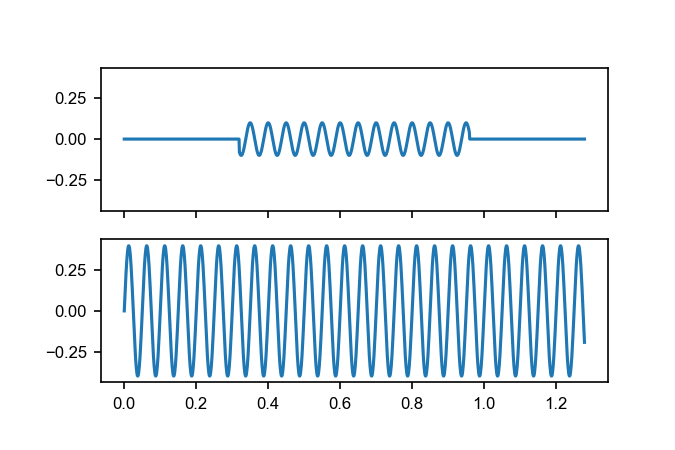

In [595]:
test = CtlTest(avgctl, 10 * 128, 10, 10, 1e9, 20e6)
test.run()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)

ax = axes[0]
ax.plot(test.tvals * 1e6, (test.data[0,:,0]))

ax = axes[1]
ax.plot(test.tvals * 1e6, (test.data[0,:,1]))

In [574]:
10e-3 * 2e8

2000000.0

# Running Benchmarks

<IPython.core.display.Javascript object>


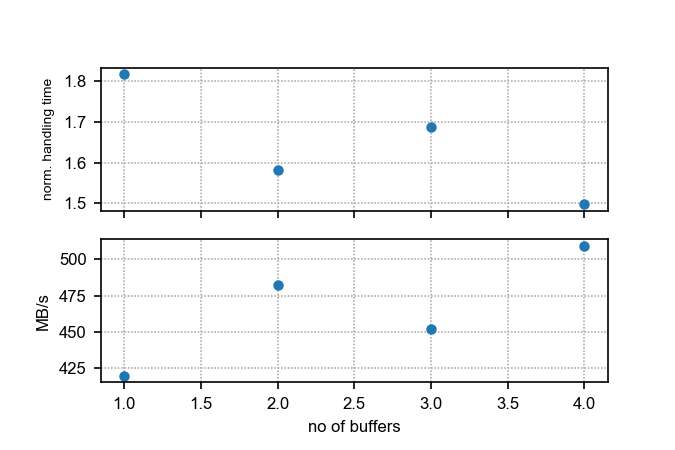

Text(0.5,0,'no of buffers')

In [598]:
nr_lst = [1, 2, 3, 4] # np.arange(10, 101, 10)
nht_lst = []
mbps_lst = []

for nr in nr_lst:
    test = CtlTest(avgctl, int(2e6), int(nr), 1, 2e8, 20e6)
    _, _, nht, mbps = test.run()
    nht_lst.append(nht)
    mbps_lst.append(mbps)
    

fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(nr_lst, nht_lst, 'o')
ax.grid(dashes=[1,1])
ax.set_ylabel('norm. handling time', size='small')

ax = axes[1]
ax.plot(nr_lst, mbps_lst, 'o')
ax.grid(dashes=[1,1])
ax.set_ylabel('MB/s')
ax.set_xlabel('no of buffers')